In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import time
import torchvision.transforms as transforms
from PIL import Image

In [2]:
# Google Drive를 Colab에 Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 해당 경로로 이동
! cd drive/MyDrive/dataset

In [4]:
# 현재 작업 디렉터리의 경로를 출력
!pwd

/content


In [5]:
# 경로에 있는 파일 및 폴더를 나열
! ls drive/MyDrive/dataset

dataset.zip  test  train  trained_model_final.pt  val


In [6]:
data_dir = 'drive/MyDrive/dataset'

In [7]:
# train, val datasets에 대한 transforms를 정의
data_transforms = {
    'train': transforms.Compose([
        # 랜덤하게 이미지 변형 (이미지 증강)
        transforms.RandomResizedCrop(224),  # 크기 조정, 224x224 크기로 자름
        transforms.RandomHorizontalFlip(p=0.5),  # 수평으로 뒤집음
        transforms.RandomVerticalFlip(p=0.5),  # 좌우로 뒤집기
        transforms.RandomApply([transforms.RandomRotation(20, interpolation=Image.BILINEAR)], p=0.5),  # 20도 회전,  # 20도 회전
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),  # 원근 조절
        # 이미지를 텐서로 전환
        transforms.ToTensor(),
        # 이미지 정규화
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 이미지를 정규화
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # 이미지 크기를 256x256으로 조정
        transforms.CenterCrop(224),  # 가운데 부분을 224x224로 자름
        transforms.ToTensor(),  # 이미지를 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 이미지를 정규화
    ]),
}

In [8]:
# 이미지 데이터셋 불러오기
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# 학습 데이터셋에 포함된 클래스들의 목록 저장
class_names = image_datasets['train'].classes

In [9]:
# pretrained mobilenetv2 불러오기
model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 84.4MB/s]


In [10]:
# 모델의 분류 레이어를 변경하여 클래스 수에 맞게 조정
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

In [11]:
# train과 val dataset 비율을 사진 개수만큼으로 설정 (9:1)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 666, 'val': 74}

In [12]:
# train과 val 폴더 만들기
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=4)
}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
# loss function 과 optimizer를 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [16]:
# 클래스 리스트 출력 (순서대로 들어감)
image_datasets['train'].classes

['cups', 'makju', 'soju']

In [14]:
# 모델 train

# step별 loss를 저장할 리스트 생성
train_loss = []  # 각 step에서의 train loss
val_loss = []  # 각 step에서의 validation loss

def train_model(model, criterion, optimizer, num_epochs):
    """학습 모델"""

    # 총 train 실행시간
    global time_amount

    for epoch in range(num_epochs):
        # 시작 시각 기록
        start_time = time.time()

        # 현재 epoch 횟수 출력
        print(f'{epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':  # train 모드
                model.train()
            else:                 # validation 모드
                model.eval()

            running_loss = 0.0    # loss값 초기화
            corrects = 0          # 맞은 개수 초기화

            # 학습 단계와 검증 단계를 반복
            for step, (inputs, labels) in enumerate(dataloaders[phase]):  # enumerate를 사용하여 step 정보 얻기

                # 입력 데이터와 레이블을 GPU로 이동
                inputs, labels = inputs.to(device), labels.to(device)

                # optimizer의 gradient를 초기화
                optimizer.zero_grad()

                # 학습 모드인 경우에만 gradient 계산을 활성화
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # 모델에 입력 데이터를 전달하여 예측값
                    _, preds = torch.max(outputs, 1)  # 예측값 중에서 가장 높은 확률을 가진 클래스를 선택
                    loss = criterion(outputs, labels)  # 손실을 계산

                    if phase == 'train':  # train 모드
                        loss.backward()  # 손실을 역전파하여 gradient를 계산
                        optimizer.step()  # optimizer를 사용하여 가중치를 업데이트

                # step별 loss 값을 리스트에 저장
                if phase == 'train':  # train 모드
                    train_loss.append(loss.item())
                else:                 # validation 모드
                    val_loss.append(loss.item())

                running_loss += loss.item() * inputs.size(0)  # 현재 단계에서의 손실을 현재까지의 누적 손실에 추가
                corrects += torch.sum(preds == labels.data)  # 현재 단계에서 정확하게 예측한 샘플의 수 세기

            epoch_loss = running_loss / dataset_sizes[phase]  # 에폭별 손실값 계산
            epoch_acc = corrects.double() / dataset_sizes[phase]  # 에폭별 정확도 계산

            print(f'{phase} Loss: {epoch_loss:.4f}  /  Acc: {epoch_acc:.4f}')

        # 종료 시각 기록
        end_time = time.time()
        total_time = end_time - start_time  # 1 epoch 동안 실행 시간

        # 총 train 시간 출력을 위해 각 epoch 실행시간을 더함
        time_amount += total_time

        # epoch마다 실행시간 출력
        print(f'{epoch+1} epoch complete: {total_time//60:.0f}m {total_time%60:.0f}s')
        print('-' * 50)

    # 총 train 실행시간 출력
    print(f'Training complete :{time_amount//3600:.0f}h {time_amount//60:.0f}m {time_amount%60:.0f}s')

    return model


In [ ]:
# 모델을 train
time_amount = 0  # 총 train 시간 초기화

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = train_model(model, criterion, optimizer, num_epochs=30)

1/30
train Loss: 1.0268  /  Acc: 0.4775
val Loss: 0.8990  /  Acc: 0.6892
1 epoch complete: 0m 43s
--------------------------------------------------
2/30
train Loss: 0.8767  /  Acc: 0.6742
val Loss: 0.7604  /  Acc: 0.7973
2 epoch complete: 0m 5s
--------------------------------------------------
3/30
train Loss: 0.7562  /  Acc: 0.7718
val Loss: 0.6513  /  Acc: 0.7973
3 epoch complete: 0m 7s
--------------------------------------------------
4/30
train Loss: 0.6519  /  Acc: 0.8183
val Loss: 0.5601  /  Acc: 0.8243
4 epoch complete: 0m 7s
--------------------------------------------------
5/30
train Loss: 0.5599  /  Acc: 0.8438
val Loss: 0.4941  /  Acc: 0.8378
5 epoch complete: 0m 10s
--------------------------------------------------
6/30
train Loss: 0.5111  /  Acc: 0.8378
val Loss: 0.4438  /  Acc: 0.8784
6 epoch complete: 0m 6s
--------------------------------------------------
7/30
train Loss: 0.4625  /  Acc: 0.8604
val Loss: 0.4148  /  Acc: 0.9054
7 epoch complete: 0m 7s
-------------

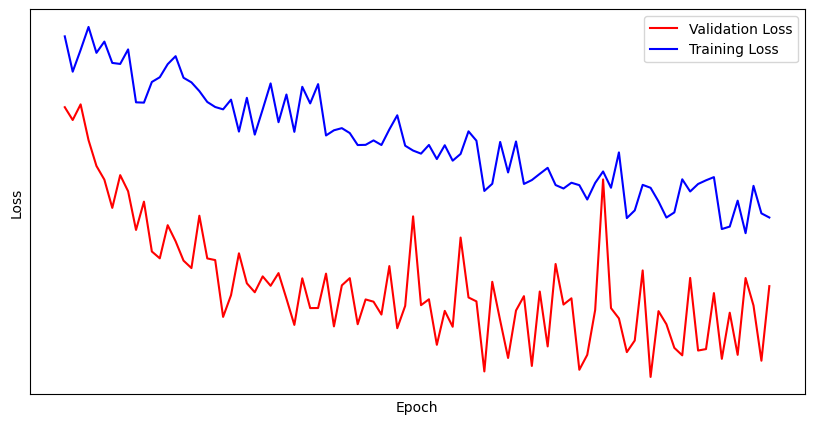

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# epoch 및 loss 추이 그래프 그리기
num_epochs = min(len(train_loss), len(val_loss))
epochs = range(1, num_epochs + 1)

# 최대값, 최소값 설정
max_loss = max(max(train_loss), max(val_loss))
min_loss = min(min(train_loss), min(val_loss))

plt.figure(figsize=(10, 5))

# epoch loss 그래프
plt.plot(epochs, val_loss[:num_epochs], 'r', label='Validation Loss')
plt.plot(epochs, train_loss[:num_epochs], 'b', label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([])  # x축 숫자 비활성화
plt.yticks([])  # y축 숫자 비활성화
plt.legend()

# 그래프를 png파일로 저장
plt.savefig('loss.png', dpi=300)

# 그래프를 화면에 출력
plt.show()

In [ ]:
# 학습한 모델을 저장
torch.save(model.state_dict(), 'trained_model.pt')